# K-Means Clustering Analysis

This notebook performs clustering analysis on Spotify songs dataset using K-Means clustering algorithm.

In [7]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================

df_clean_path = r"D:\UNH Materials\Projects\Spotify Song Recommendations\data\df_clean.csv"
df_clean = pd.read_csv(df_clean_path)

print("="*80)
print("DATA LOADING")
print("="*80)
print(f"\nDataset shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_clean.head())

DATA LOADING

Dataset shape: (85000, 32)
Columns: ['track_id', 'track_name', 'artist_name', 'album_name', 'release_date', 'genre', 'duration_ms', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'instrumentalness', 'tempo', 'stream_count', 'country', 'explicit', 'label', 'release_year', 'release_month', 'release_quarter', 'release_week', 'release_day_of_week', 'duration_min', 'popularity_bin', 'stream_category', 'key_label', 'energy_danceability', 'popularity_energy', 'instrumentalness_energy', 'mode_label']

First few rows:
           track_id              track_name    artist_name         album_name  \
0  TRK-BEBD53DA84E1         Agent every (0)    Noah Rhodes  Beautiful instead   
1  TRK-6A32496762D7           Night respond  Jennifer Cole              Table   
2  TRK-47AA7523463E  Future choice whatever  Brandon Davis      Page southern   
3  TRK-25ADA22E3B06     Bad fall pick those    Corey Jones             Spring   
4  TRK-9245F2AD996A                 Husband   

In [26]:
# ============================================================================
# STEP 2: SELECT OPTIMAL FEATURES FOR CLUSTERING
# ============================================================================

print("="*80)
print("FEATURE SELECTION")
print("="*80)

# Select optimal features for clustering
# Audio features that capture musical characteristics
numerical_features = [
    'danceability',      # How suitable a track is for dancing
    'energy',            # Perceptual measure of intensity and power
    'key',               # Key the track is in
    'loudness',          # Overall loudness in decibels
    'mode',              # Major (1) or minor (0)
    'instrumentalness', # Predicts whether a track contains vocals
    'tempo',             # Overall estimated tempo in BPM
    'duration_min',      # Duration in minutes
    'popularity',       # Popularity score (0-100)
    'explicit'          # Whether the track contains explicit content
]

# Categorical features that might help distinguish clusters
categorical_features = [
    # 'country',           # Country of origin
    # 'label'              # Record label
]

# Check which features exist in the dataset
available_numerical = [f for f in numerical_features if f in df_clean.columns]
available_categorical = [f for f in categorical_features if f in df_clean.columns]

print(f"\nSelected Numerical Features ({len(available_numerical)}):")
for feat in available_numerical:
    print(f"  - {feat}")

print(f"\nSelected Categorical Features ({len(available_categorical)}):")
for feat in available_categorical:
    print(f"  - {feat}")

# Create feature matrix
X = df_clean[available_numerical + available_categorical].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Missing values: {X.isnull().sum().sum()}")

FEATURE SELECTION

Selected Numerical Features (10):
  - danceability
  - energy
  - key
  - loudness
  - mode
  - instrumentalness
  - tempo
  - duration_min
  - popularity
  - explicit

Selected Categorical Features (0):

Feature matrix shape: (85000, 10)
Missing values: 0


In [27]:
# ============================================================================
# STEP 3: ENCODE CATEGORICAL FEATURES
# ============================================================================

print("="*80)
print("ENCODING CATEGORICAL FEATURES")
print("="*80)

# Separate numerical and categorical columns
X_numerical = X[available_numerical].copy()
X_categorical = X[available_categorical].copy()

print(f"\nNumerical features shape: {X_numerical.shape}")
print(f"Categorical features shape: {X_categorical.shape}")

# Apply One-Hot Encoding to categorical features
if len(available_categorical) > 0:
    print(f"\nApplying One-Hot Encoding to {len(available_categorical)} categorical features...")
    
    ohe = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')
    X_categorical_encoded = ohe.fit_transform(X_categorical)
    categorical_feature_names = ohe.get_feature_names_out(available_categorical)
    
    print(f"  Original categorical columns: {len(available_categorical)}")
    print(f"  Encoded categorical columns: {len(categorical_feature_names)}")
    
    # Combine numerical and encoded categorical features
    X_encoded = pd.DataFrame(
        data=np.hstack([X_numerical.values, X_categorical_encoded]),
        columns=list(available_numerical) + list(categorical_feature_names),
        index=X.index
    )
    
    # Print encoding details
    for col in available_categorical:
        print(f"  '{col}': {X[col].nunique()} unique values")
else:
    X_encoded = X_numerical.copy()

print(f"\nFinal feature matrix shape after encoding: {X_encoded.shape}")
print(f"Total features: {X_encoded.shape[1]}")

ENCODING CATEGORICAL FEATURES

Numerical features shape: (85000, 10)
Categorical features shape: (85000, 0)

Final feature matrix shape after encoding: (85000, 10)
Total features: 10


In [28]:
# ============================================================================
# STEP 4: SCALE FEATURES
# ============================================================================

print("="*80)
print("FEATURE SCALING")
print("="*80)

# StandardScaler normalizes features to have mean=0 and std=1
# This is crucial for K-means as it uses Euclidean distance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(
    data=X_scaled,
    columns=X_encoded.columns,
    index=X_encoded.index
)

print(f"\nScaling completed!")
print(f"Scaled feature matrix shape: {X_scaled_df.shape}")
print(f"\nScaled feature statistics:")
print(X_scaled_df.describe().round(3))

print("\n" + "="*80)
print("DATA PREPARATION COMPLETE")
print("="*80)

FEATURE SCALING

Scaling completed!
Scaled feature matrix shape: (85000, 10)

Scaled feature statistics:
       danceability     energy        key   loudness     mode  \
count     85000.000  85000.000  85000.000  85000.000  85000.0   
mean          0.000     -0.000      0.000      0.000      0.0   
std           1.000      1.000      1.000      1.000      1.0   
min          -1.738     -1.735     -1.597     -1.731     -1.0   
25%          -0.852     -0.877     -0.801     -0.864     -1.0   
50%          -0.003     -0.019      0.140      0.002      1.0   
75%           0.884      0.874      1.009      0.865      1.0   
max           1.733      1.732      1.588      1.731      1.0   

       instrumentalness      tempo  duration_min  popularity   explicit  
count         85000.000  85000.000     85000.000   85000.000  85000.000  
mean              0.000     -0.000        -0.000       0.000     -0.000  
std               1.000      1.000         1.000       1.000      1.000  
min          

In [12]:
# ============================================================================
# STEP 5: ELBOW METHOD TO FIND OPTIMAL NUMBER OF CLUSTERS
# ============================================================================

print("="*80)
print("ELBOW METHOD: FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*80)

# Range of k values to test
k_range = range(2, 11)  # Testing k from 2 to 10
inertias = []
silhouette_scores = []

print(f"\nTesting k values from {min(k_range)} to {max(k_range)}...")
print("This may take a few minutes...")

for k in k_range:
    print(f"  Testing k={k}...", end=" ")
    
    # Initialize and fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    
    # Calculate inertia (within-cluster sum of squares)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"✓ (Inertia: {kmeans.inertia_:.2f}, Silhouette: {silhouette_avg:.3f})")

print("\nElbow method computation completed!")

ELBOW METHOD: FINDING OPTIMAL NUMBER OF CLUSTERS

Testing k values from 2 to 10...
This may take a few minutes...
  Testing k=2... ✓ (Inertia: 2282825.26, Silhouette: 0.044)
  Testing k=3... ✓ (Inertia: 2200400.66, Silhouette: 0.060)
  Testing k=4... ✓ (Inertia: 2118337.06, Silhouette: 0.074)
  Testing k=5... ✓ (Inertia: 2045044.33, Silhouette: 0.085)
  Testing k=6... ✓ (Inertia: 1950285.51, Silhouette: 0.109)
  Testing k=7... ✓ (Inertia: 1813089.90, Silhouette: 0.153)
  Testing k=8... ✓ (Inertia: 1718680.34, Silhouette: 0.174)
  Testing k=9... ✓ (Inertia: 1624155.10, Silhouette: 0.196)
  Testing k=10... ✓ (Inertia: 1529846.84, Silhouette: 0.218)

Elbow method computation completed!


ELBOW METHOD VISUALIZATION


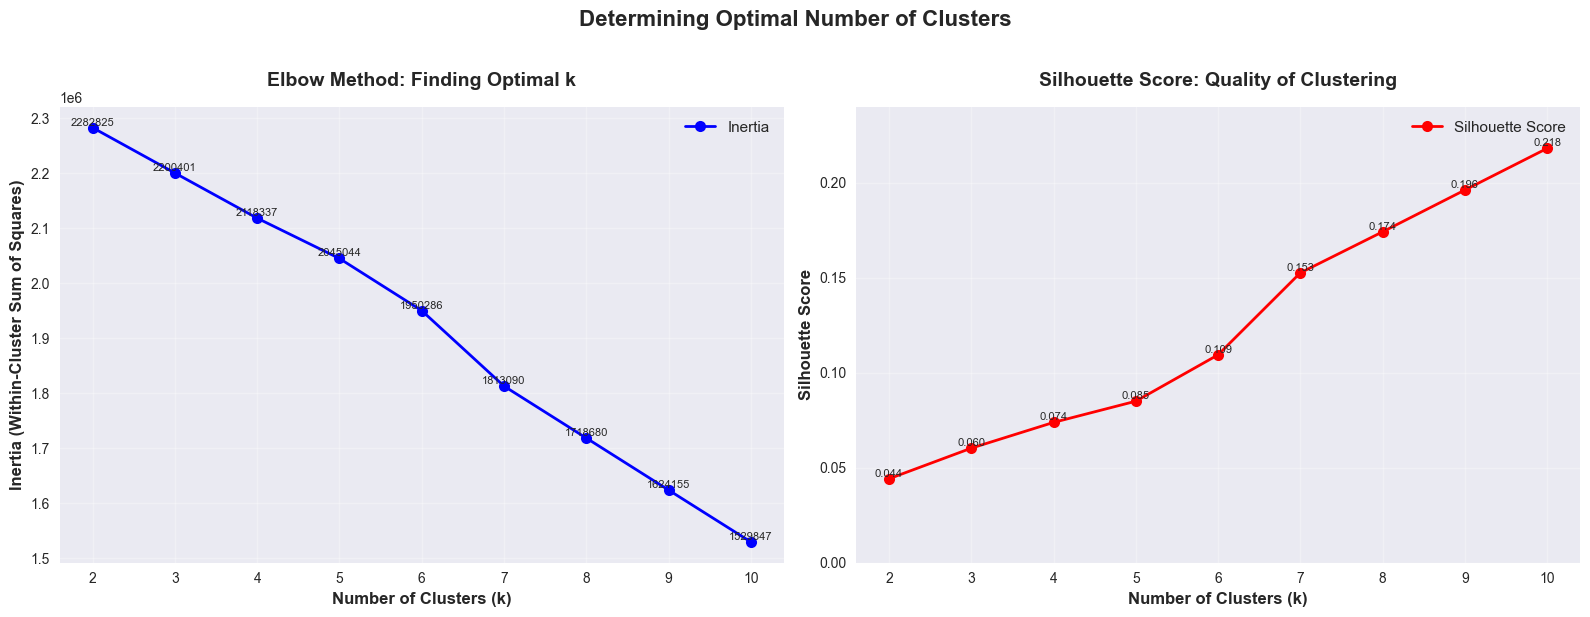


Optimal k based on Silhouette Score: 10 (Score: 0.218)

Inertia values:
  k= 2: 2282825.26
  k= 3: 2200400.66
  k= 4: 2118337.06
  k= 5: 2045044.33
  k= 6: 1950285.51
  k= 7: 1813089.90
  k= 8: 1718680.34
  k= 9: 1624155.10
  k=10: 1529846.84

Silhouette scores:
  k= 2: 0.044
  k= 3: 0.060
  k= 4: 0.074
  k= 5: 0.085
  k= 6: 0.109
  k= 7: 0.153
  k= 8: 0.174
  k= 9: 0.196
  k=10: 0.218


In [13]:
# ============================================================================
# STEP 6: VISUALIZE ELBOW METHOD RESULTS
# ============================================================================

print("="*80)
print("ELBOW METHOD VISUALIZATION")
print("="*80)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Elbow Curve (Inertia)
ax1 = axes[0]
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8, label='Inertia')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
ax1.set_title('Elbow Method: Finding Optimal k', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Add value labels on points
for k, inertia in zip(k_range, inertias):
    ax1.text(k, inertia, f'{inertia:.0f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Silhouette Score
ax2 = axes[1]
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8, label='Silhouette Score')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score: Quality of Clustering', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_ylim([0, max(silhouette_scores) * 1.1])

# Add value labels on points
for k, score in zip(k_range, silhouette_scores):
    ax2.text(k, score, f'{score:.3f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Determining Optimal Number of Clusters', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Find optimal k based on elbow method and silhouette score
# Elbow: Look for the "elbow" where the rate of decrease sharply changes
# Silhouette: Higher is better (closer to 1 is best)

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
max_silhouette = max(silhouette_scores)

print(f"\nOptimal k based on Silhouette Score: {optimal_k_silhouette} (Score: {max_silhouette:.3f})")
print(f"\nInertia values:")
for k, inertia in zip(k_range, inertias):
    print(f"  k={k:2d}: {inertia:.2f}")

print(f"\nSilhouette scores:")
for k, score in zip(k_range, silhouette_scores):
    print(f"  k={k:2d}: {score:.3f}")

In [ ]:
# ============================================================================
# STEP 7: DETERMINE OPTIMAL K
# ============================================================================

print("="*80)
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("="*80)

# Method 1: Elbow method - calculate rate of change in inertia
inertia_changes = np.diff(inertias)
inertia_change_rates = np.diff(inertia_changes)

# Find the elbow (where the rate of change is maximum)
# We look for the point where the decrease in inertia slows down significantly
elbow_idx = np.argmax(np.abs(inertia_change_rates)) + 2  # +2 because of double diff
optimal_k_elbow = k_range[elbow_idx] if elbow_idx < len(k_range) else optimal_k_silhouette

# Method 2: Silhouette score (already calculated)
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]

# Use silhouette-based optimal k (generally more reliable)
optimal_k = optimal_k_silhouette

print(f"\nAnalysis Results:")
print(f"  Elbow method suggests: k = {optimal_k_elbow}")
print(f"  Silhouette method suggests: k = {optimal_k_silhouette}")
print(f"\n  Selected optimal k: {optimal_k} (based on Silhouette Score)")
print(f"  Silhouette Score at k={optimal_k}: {silhouette_scores[optimal_k - min(k_range)]:.3f}")
print(f"  Inertia at k={optimal_k}: {inertias[optimal_k - min(k_range)]:.2f}")

In [15]:
# ============================================================================
# STEP 8: PERFORM K-MEANS CLUSTERING WITH OPTIMAL K
# ============================================================================

print("="*80)
print(f"PERFORMING K-MEANS CLUSTERING WITH k={optimal_k}")
print("="*80)

# Initialize and fit K-means with optimal k
kmeans_final = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=10,  # Number of times to run with different centroid seeds
    max_iter=300  # Maximum number of iterations
)

print(f"\nFitting K-means model with k={optimal_k}...")
kmeans_final.fit(X_scaled)

# Get cluster labels
cluster_labels = kmeans_final.labels_

# Add cluster labels to original dataframe
df_clean['cluster'] = cluster_labels

print(f"\nClustering completed!")
print(f"\nCluster distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"  Cluster {cluster_id}: {count:,} songs ({percentage:.2f}%)")

# Calculate final metrics
final_inertia = kmeans_final.inertia_
final_silhouette = silhouette_score(X_scaled, cluster_labels)

print(f"\nFinal Clustering Metrics:")
print(f"  Inertia: {final_inertia:.2f}")
print(f"  Silhouette Score: {final_silhouette:.3f}")

PERFORMING K-MEANS CLUSTERING WITH k=10

Fitting K-means model with k=10...

Clustering completed!

Cluster distribution:
  Cluster 0: 8,559 songs (10.07%)
  Cluster 1: 8,582 songs (10.10%)
  Cluster 2: 8,490 songs (9.99%)
  Cluster 3: 8,458 songs (9.95%)
  Cluster 4: 8,338 songs (9.81%)
  Cluster 5: 8,620 songs (10.14%)
  Cluster 6: 8,629 songs (10.15%)
  Cluster 7: 8,415 songs (9.90%)
  Cluster 8: 8,551 songs (10.06%)
  Cluster 9: 8,358 songs (9.83%)

Final Clustering Metrics:
  Inertia: 1529846.84
  Silhouette Score: 0.218


In [16]:
# ============================================================================
# STEP 9: CLUSTER ANALYSIS
# ============================================================================

print("="*80)
print("CLUSTER CHARACTERISTICS ANALYSIS")
print("="*80)

# Analyze cluster characteristics using original numerical features
cluster_analysis = df_clean.groupby('cluster')[available_numerical].mean()

print(f"\nAverage feature values by cluster:")
print("-"*80)
print(cluster_analysis.round(3).to_string())
print("-"*80)

# Analyze genre distribution in each cluster
if 'genre' in df_clean.columns:
    print(f"\nGenre distribution by cluster:")
    genre_cluster = pd.crosstab(df_clean['cluster'], df_clean['genre'], normalize='index') * 100
    print(genre_cluster.round(2).to_string())
    print("-"*80)

CLUSTER CHARACTERISTICS ANALYSIS

Average feature values by cluster:
--------------------------------------------------------------------------------
         danceability  energy    key  loudness   mode  instrumentalness    tempo  duration_min  popularity  explicit
cluster                                                                                                             
0               0.520   0.503  5.558   -28.135  0.512             0.401  130.954         4.253      48.333     0.207
1               0.518   0.509  5.510   -27.988  0.502             0.400  129.898         4.229      48.351     0.202
2               0.517   0.504  5.477   -28.036  0.496             0.399  130.188         4.215      48.314     0.205
3               0.522   0.504  5.475   -27.868  0.506             0.396  129.014         4.252      48.414     0.201
4               0.525   0.503  5.473   -28.001  0.493             0.404  129.919         4.268      47.956     0.198
5               0.520   0.507  

PCA VISUALIZATION OF CLUSTERS

PCA Results:
  PC1 explains 4.11% of variance
  PC2 explains 4.11% of variance
  Total variance explained: 8.22%


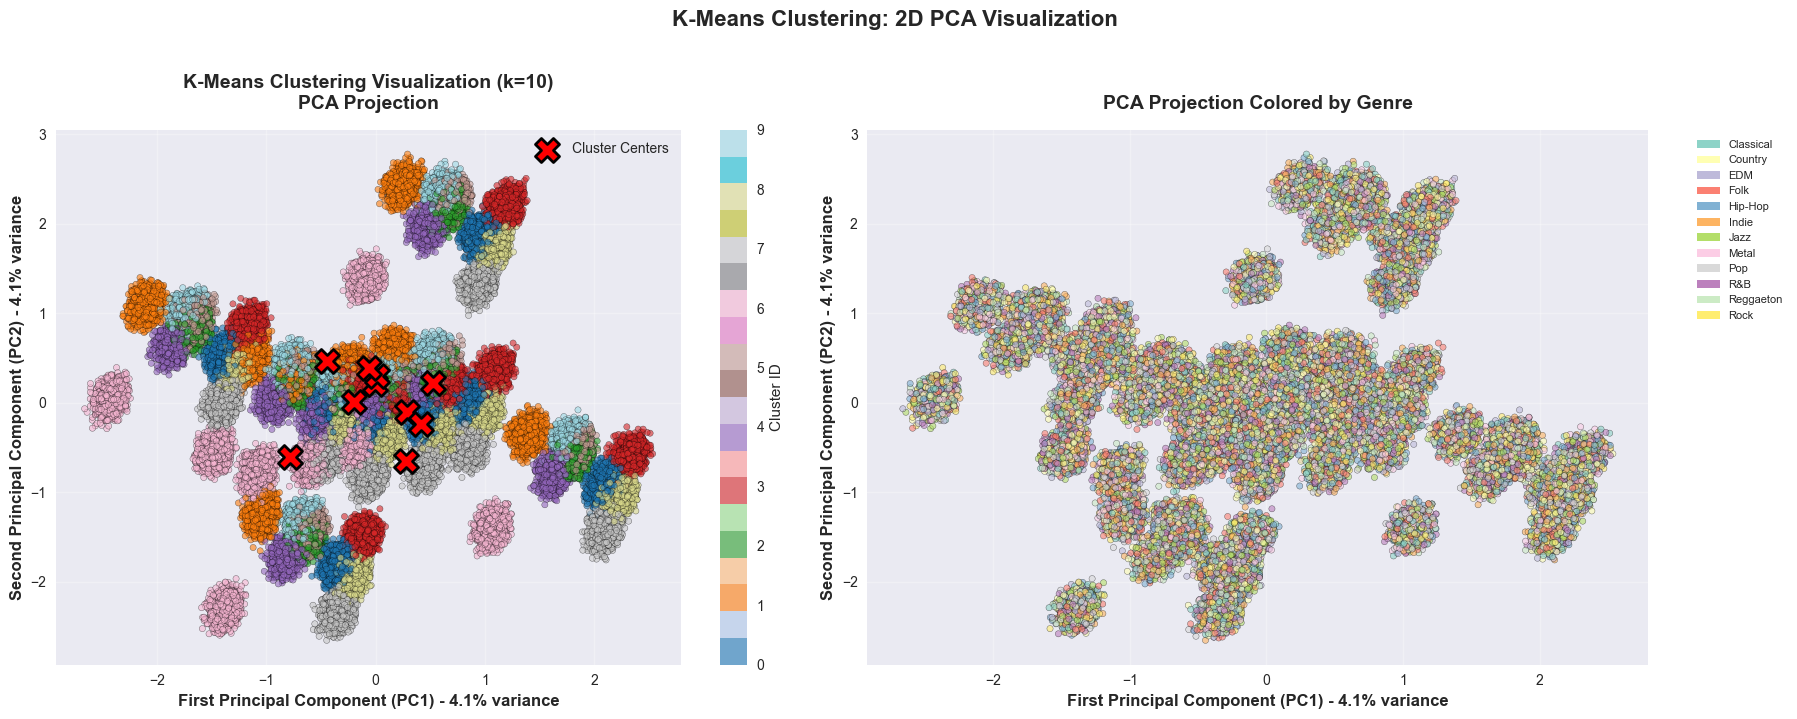


Visualization completed!


In [17]:
# ============================================================================
# STEP 10: VISUALIZE CLUSTERS USING PCA
# ============================================================================

print("="*80)
print("PCA VISUALIZATION OF CLUSTERS")
print("="*80)

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
total_variance = explained_variance.sum()

print(f"\nPCA Results:")
print(f"  PC1 explains {explained_variance[0]*100:.2f}% of variance")
print(f"  PC2 explains {explained_variance[1]*100:.2f}% of variance")
print(f"  Total variance explained: {total_variance*100:.2f}%")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Clusters colored by cluster ID
ax1 = axes[0]
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                     cmap='tab20', alpha=0.6, s=20, edgecolors='black', linewidth=0.3)
ax1.set_xlabel(f'First Principal Component (PC1) - {explained_variance[0]*100:.1f}% variance', 
               fontsize=12, fontweight='bold')
ax1.set_ylabel(f'Second Principal Component (PC2) - {explained_variance[1]*100:.1f}% variance', 
               fontsize=12, fontweight='bold')
ax1.set_title(f'K-Means Clustering Visualization (k={optimal_k})\nPCA Projection', 
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Cluster ID')

# Plot cluster centers in PCA space
cluster_centers_pca = pca.transform(kmeans_final.cluster_centers_)
ax1.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], 
           c='red', marker='X', s=300, edgecolors='black', linewidth=2, 
           label='Cluster Centers', zorder=5)
ax1.legend()

# Plot 2: Clusters colored by genre (if available)
ax2 = axes[1]
if 'genre' in df_clean.columns:
    # Map genres to colors
    unique_genres = sorted(df_clean['genre'].unique())
    genre_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_genres)))
    genre_color_map = dict(zip(unique_genres, genre_colors))
    
    colors_by_genre = [genre_color_map[g] for g in df_clean['genre']]
    
    scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=colors_by_genre, 
                         alpha=0.6, s=20, edgecolors='black', linewidth=0.3)
    ax2.set_xlabel(f'First Principal Component (PC1) - {explained_variance[0]*100:.1f}% variance', 
                  fontsize=12, fontweight='bold')
    ax2.set_ylabel(f'Second Principal Component (PC2) - {explained_variance[1]*100:.1f}% variance', 
                  fontsize=12, fontweight='bold')
    ax2.set_title('PCA Projection Colored by Genre', 
                 fontsize=14, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3)
    
    # Add legend for genres (sample)
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=genre_color_map[g], label=g) for g in unique_genres[:12]]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
else:
    ax2.text(0.5, 0.5, 'Genre information not available', 
            ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('PCA Projection', fontsize=14, fontweight='bold')

plt.suptitle('K-Means Clustering: 2D PCA Visualization', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nVisualization completed!")

ADDITIONAL CLUSTER ANALYSIS VISUALIZATIONS


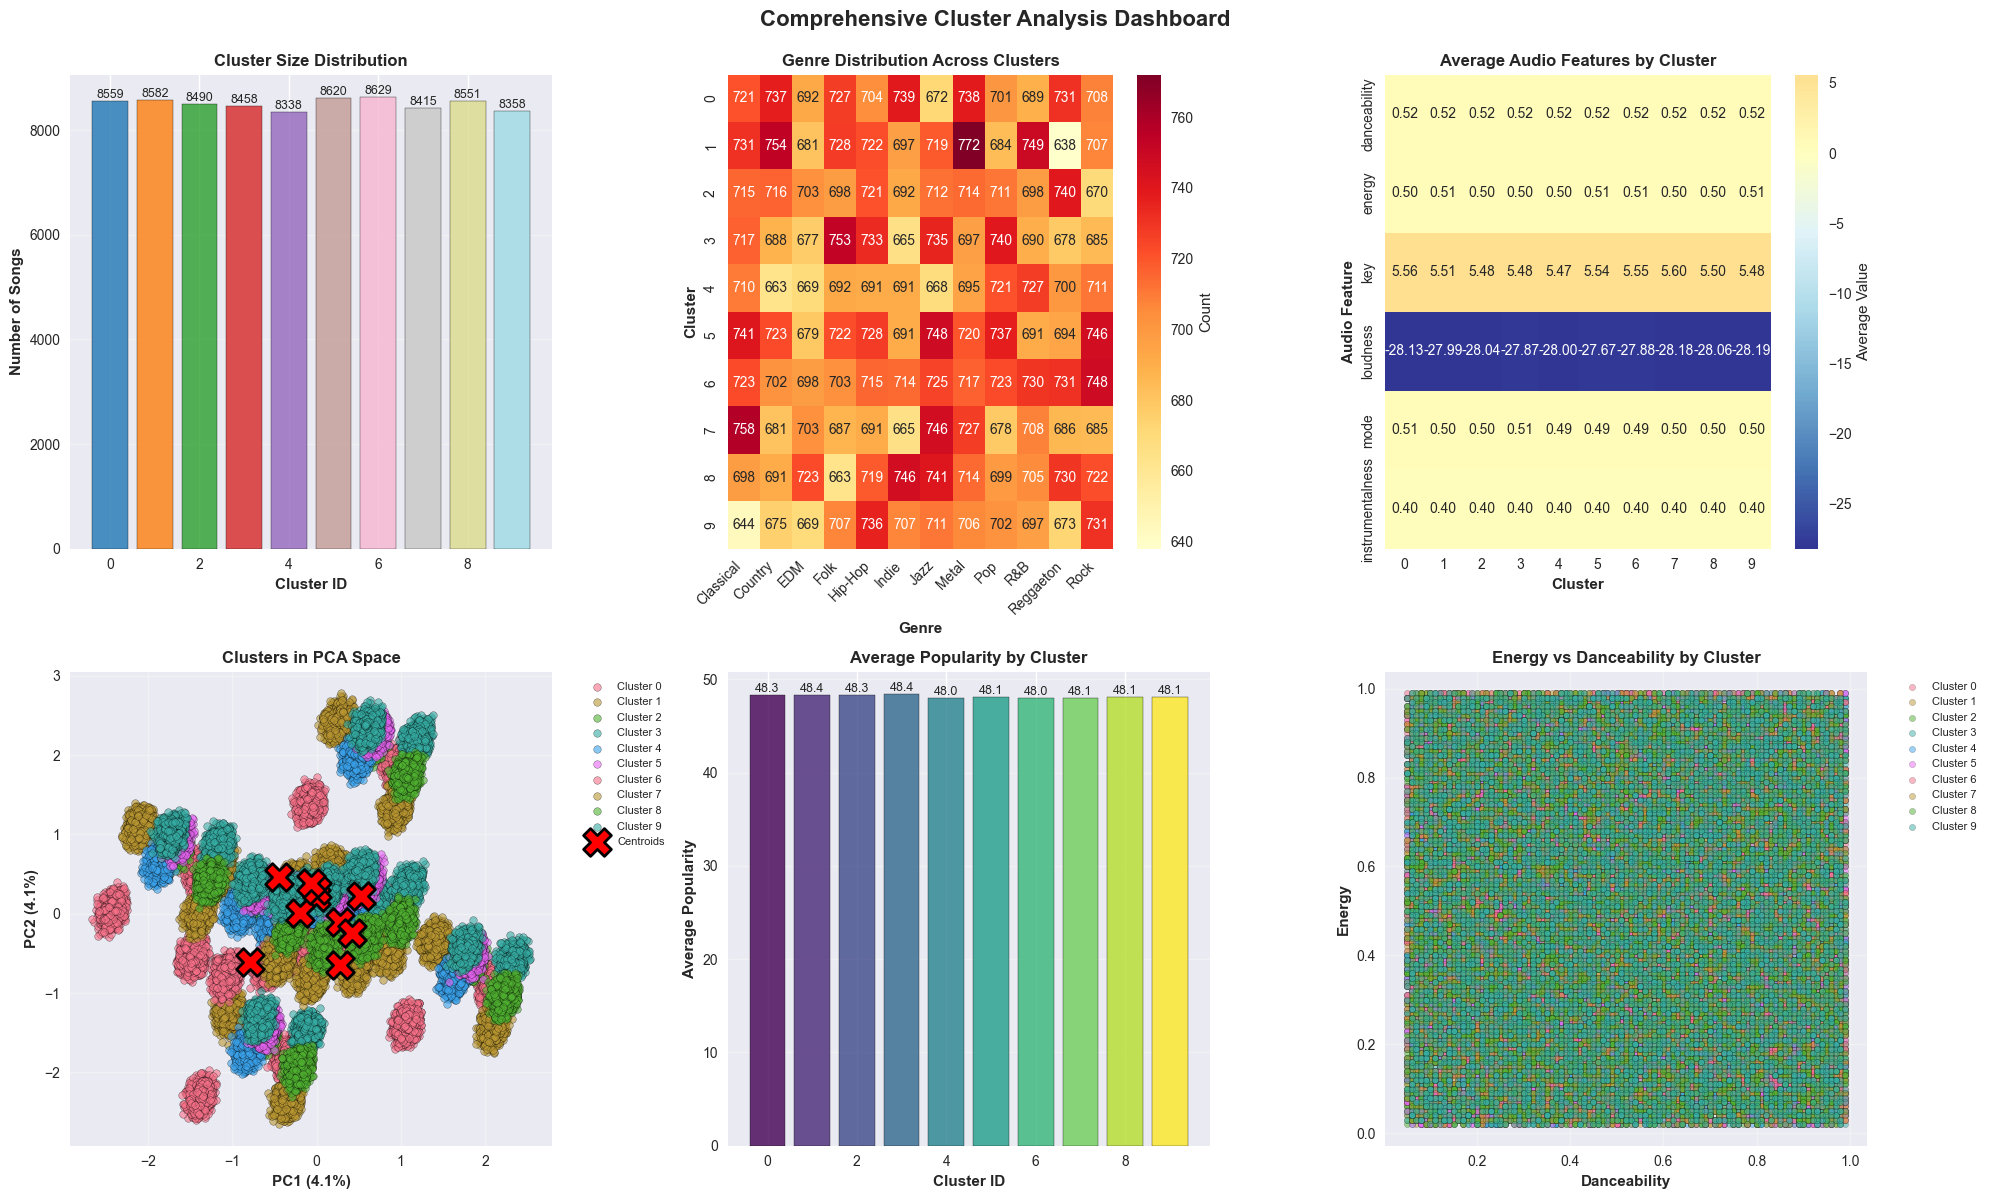


Additional visualizations completed!


In [18]:
# ============================================================================
# STEP 11: ADDITIONAL CLUSTER VISUALIZATIONS
# ============================================================================

print("="*80)
print("ADDITIONAL CLUSTER ANALYSIS VISUALIZATIONS")
print("="*80)

# Create a comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Cluster size distribution
ax1 = plt.subplot(2, 3, 1)
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
bars = ax1.bar(cluster_counts.index, cluster_counts.values, 
               color=plt.cm.tab20(np.linspace(0, 1, len(cluster_counts))), 
               edgecolor='black', alpha=0.8)
ax1.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Songs', fontsize=11, fontweight='bold')
ax1.set_title('Cluster Size Distribution', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 2. Genre distribution in clusters (heatmap)
ax2 = plt.subplot(2, 3, 2)
if 'genre' in df_clean.columns:
    genre_cluster_crosstab = pd.crosstab(df_clean['cluster'], df_clean['genre'])
    sns.heatmap(genre_cluster_crosstab, annot=True, fmt='d', cmap='YlOrRd', 
                ax=ax2, cbar_kws={'label': 'Count'})
    ax2.set_xlabel('Genre', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Cluster', fontsize=11, fontweight='bold')
    ax2.set_title('Genre Distribution Across Clusters', fontsize=12, fontweight='bold')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Average audio features by cluster (heatmap)
ax3 = plt.subplot(2, 3, 3)
cluster_features = df_clean.groupby('cluster')[available_numerical[:6]].mean()
sns.heatmap(cluster_features.T, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            ax=ax3, cbar_kws={'label': 'Average Value'}, center=0)
ax3.set_xlabel('Cluster', fontsize=11, fontweight='bold')
ax3.set_ylabel('Audio Feature', fontsize=11, fontweight='bold')
ax3.set_title('Average Audio Features by Cluster', fontsize=12, fontweight='bold')

# 4. PCA with cluster centers
ax4 = plt.subplot(2, 3, 4)
for cluster_id in range(optimal_k):
    mask = cluster_labels == cluster_id
    ax4.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               label=f'Cluster {cluster_id}', alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
ax4.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], 
           c='red', marker='X', s=400, edgecolors='black', linewidth=2, 
           label='Centroids', zorder=5)
ax4.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)', fontsize=11, fontweight='bold')
ax4.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)', fontsize=11, fontweight='bold')
ax4.set_title('Clusters in PCA Space', fontsize=12, fontweight='bold')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Popularity distribution by cluster
ax5 = plt.subplot(2, 3, 5)
if 'popularity' in df_clean.columns:
    cluster_popularity = df_clean.groupby('cluster')['popularity'].mean()
    bars = ax5.bar(cluster_popularity.index, cluster_popularity.values,
                   color=plt.cm.viridis(np.linspace(0, 1, len(cluster_popularity))),
                   edgecolor='black', alpha=0.8)
    ax5.set_xlabel('Cluster ID', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Average Popularity', fontsize=11, fontweight='bold')
    ax5.set_title('Average Popularity by Cluster', fontsize=12, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# 6. Energy vs Danceability by cluster
ax6 = plt.subplot(2, 3, 6)
if 'energy' in df_clean.columns and 'danceability' in df_clean.columns:
    for cluster_id in range(optimal_k):
        mask = cluster_labels == cluster_id
        ax6.scatter(df_clean.loc[mask, 'danceability'], 
                   df_clean.loc[mask, 'energy'],
                   label=f'Cluster {cluster_id}', alpha=0.5, s=20, edgecolors='black', linewidth=0.2)
    ax6.set_xlabel('Danceability', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Energy', fontsize=11, fontweight='bold')
    ax6.set_title('Energy vs Danceability by Cluster', fontsize=12, fontweight='bold')
    ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax6.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Cluster Analysis Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nAdditional visualizations completed!")

In [19]:
# ============================================================================
# STEP 12: FINAL SUMMARY
# ============================================================================

print("="*80)
print("CLUSTERING ANALYSIS - FINAL SUMMARY")
print("="*80)

print(f"\nDataset Information:")
print(f"  Total samples: {len(df_clean):,}")
print(f"  Features used: {X_encoded.shape[1]}")
print(f"    - Numerical features: {len(available_numerical)}")
print(f"    - Encoded categorical features: {X_encoded.shape[1] - len(available_numerical)}")

print(f"\nClustering Results:")
print(f"  Optimal number of clusters (k): {optimal_k}")
print(f"  Final Inertia: {final_inertia:.2f}")
print(f"  Final Silhouette Score: {final_silhouette:.3f}")
print(f"  PCA Variance Explained: {total_variance*100:.2f}%")

print(f"\nCluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"  Cluster {cluster_id}: {count:,} songs ({percentage:.2f}%)")

print(f"\nKey Insights:")
print(f"  1. The elbow method and silhouette score were used to determine optimal k={optimal_k}")
print(f"  2. Clusters are visualized in 2D using PCA dimensionality reduction")
print(f"  3. Each cluster represents songs with similar audio characteristics")
print(f"  4. The clustering can be used for music recommendation and genre analysis")

print("\n" + "="*80)
print("CLUSTERING ANALYSIS COMPLETE")
print("="*80)

CLUSTERING ANALYSIS - FINAL SUMMARY

Dataset Information:
  Total samples: 85,000
  Features used: 28
    - Numerical features: 10
    - Encoded categorical features: 18

Clustering Results:
  Optimal number of clusters (k): 10
  Final Inertia: 1529846.84
  Final Silhouette Score: 0.218
  PCA Variance Explained: 8.22%

Cluster Distribution:
  Cluster 0: 8,559 songs (10.07%)
  Cluster 1: 8,582 songs (10.10%)
  Cluster 2: 8,490 songs (9.99%)
  Cluster 3: 8,458 songs (9.95%)
  Cluster 4: 8,338 songs (9.81%)
  Cluster 5: 8,620 songs (10.14%)
  Cluster 6: 8,629 songs (10.15%)
  Cluster 7: 8,415 songs (9.90%)
  Cluster 8: 8,551 songs (10.06%)
  Cluster 9: 8,358 songs (9.83%)

Key Insights:
  1. The elbow method and silhouette score were used to determine optimal k=10
  2. Clusters are visualized in 2D using PCA dimensionality reduction
  3. Each cluster represents songs with similar audio characteristics
  4. The clustering can be used for music recommendation and genre analysis

CLUSTERING 